# Reading data from csv

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

df = pd.read_csv('enron_spam_data.csv')
#display(df)

# Data Cleaning 

In [3]:
import re

def regexClean(message_content):
    # convert everything to string
    # getting a "passing a float" error otherwise
    message_content = str(message_content) 
    
    # remove all URLs
    message_content = re.sub(r'(http|https|ftp)://[a-zA-Z0-9\\./]+', ' ', str(message_content)) 

    # remove all emails
    message_content = re.sub(r'[A-Za-z0-9._\\-]+@[A-Za-z0-9-]*\\.[a-z]{2,3}','',str(message_content))

    # remove all tags
    # https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string
    message_content = re.sub(r'<[^<]+?>', '', str(message_content)) 

    # remove newline
    message_content = message_content.replace('\n', ' ')

    # convert all chars to lowercase
    message_content = message_content.lower()
    return message_content

# make a copy of the df 
df_with_punct_numb_removed = df.copy();

df['Cleaned_Message'] = df['Message'].apply(regexClean)

#print(df[['Message', 'Cleaned_Message']].head())
#df_with_punct_numb_removed.head()

## punctuation and digits removed 

In [4]:
from string import punctuation

def punct_removal(message_content):
    message_content = str(message_content)
    
    # https://regexr.com/
    
    # remove digits
    message_content = re.sub(r'\d+', ' ', message_content)

    # remove all non-alphabetic characters
    message_content = message_content.replace(r'[^a-zA-Z]', '') 

    #remove punctuation
    # https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string
    message_content = message_content.translate(str.maketrans('', '', punctuation))
    
    return message_content

df_with_punct_numb_removed['Cleaned_Message'] = df_with_punct_numb_removed['Message'].apply(punct_removal)

#display(df_with_punct_numb_removed)

# Stemming and Stop word removal

Stemming -> removes es, ies, s
dog, dogs -> dog

- snowball stemmer: Porter2, enhanced adv version of porter stemmer
- porter stemmer

tokenization

stop word removal: remove of, the and common prepositions and words that do not offer much new information

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

def stem_stopword_rem(message_content):
    message_content = str(message_content)

    # remove english stop words
    stop_words = stopwords.words('english')
    words = [eachword for eachword in message_content.split() if eachword not in stop_words]

    # stem words w Snowball stemmer
    stemmer = SnowballStemmer('english')
    stemmed = [stemmer.stem(eachword) for eachword in words]

    stemmed_stopword_removed_message = ' '.join(stemmed)

    return stemmed_stopword_removed_message

df_stem_stopword_removed = df_with_punct_numb_removed.copy()
df_stem_stopword_removed['Cleaned_Message'] = df_with_punct_numb_removed['Cleaned_Message'].apply(stem_stopword_rem)

#display(df_stem_stopword_removed)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/datascience/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# TFIDF 

In [6]:
# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df_stem_stopword_removed['Cleaned_Message']).toarray()

# Convert the vectorized data to a DataFrame for better visualization
vectorized_df = pd.DataFrame(X, columns=vectorizer.get_feature_names())

# Display the first few rows of the vectorized data
print(vectorized_df.head())

    aa   ab  abil  abl  abroad  absenc  absolut  abus   ac  academ  ...   yes  \
0  0.0  0.0   0.0  0.0     0.0     0.0      0.0   0.0  0.0     0.0  ...   0.0   
1  0.0  0.0   0.0  0.0     0.0     0.0      0.0   0.0  0.0     0.0  ...   0.0   
2  0.0  0.0   0.0  0.0     0.0     0.0      0.0   0.0  0.0     0.0  ...   0.0   
3  0.0  0.0   0.0  0.0     0.0     0.0      0.0   0.0  0.0     0.0  ...   0.0   
4  0.0  0.0   0.0  0.0     0.0     0.0      0.0   0.0  0.0     0.0  ...   0.0   

   yesterday  yet  yield   yo  york  young  zero  zimin  zone  
0   0.000000  0.0    0.0  0.0   0.0    0.0   0.0    0.0   0.0  
1   0.000000  0.0    0.0  0.0   0.0    0.0   0.0    0.0   0.0  
2   0.000000  0.0    0.0  0.0   0.0    0.0   0.0    0.0   0.0  
3   0.054077  0.0    0.0  0.0   0.0    0.0   0.0    0.0   0.0  
4   0.000000  0.0    0.0  0.0   0.0    0.0   0.0    0.0   0.0  

[5 rows x 3000 columns]


In [7]:
# Define the target variable
y = df['Spam/Ham'] 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for RandomForestClassifier
parameter_grid = {
    'n_estimators': [100],
    'max_features': ['auto'],
    'max_depth': [5],
    'criterion': ['gini']
}

# Perform Grid Search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), parameter_grid, cv=2, n_jobs=1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Predict on the test set with the best model
y_pred = best_model.predict(X_test)

# Print the results
print("Best Hyperparameters:", best_params)
print("Best Grid Search CV Score:", grid_search.best_score_)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] criterion=gini, max_depth=5, max_features=auto, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=5, max_features=auto, n_estimators=100, total=   3.9s
[CV] criterion=gini, max_depth=5, max_features=auto, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, max_features=auto, n_estimators=100, total=   3.5s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.9s finished


Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 100}
Best Grid Search CV Score: 0.879875426368
Accuracy: 0.8846381969157769
             precision    recall  f1-score   support

        ham       0.99      0.77      0.87      3276
       spam       0.82      0.99      0.90      3468

avg / total       0.90      0.88      0.88      6744



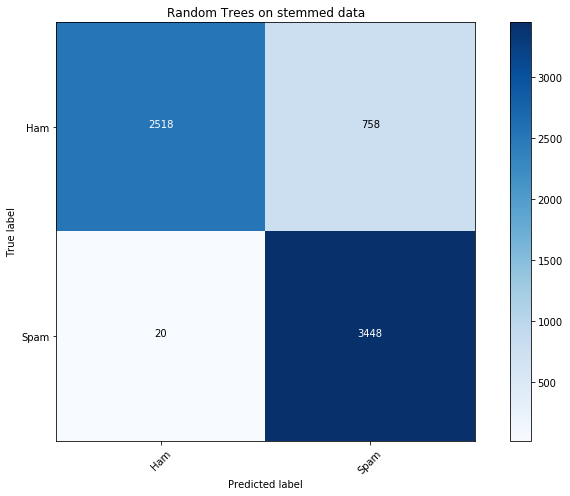

In [8]:
# Confusion Matrix
def plot_confusion_matrix(y_test, y_pred, class_labels=None, title='Confusion Matrix', cmap=plt.cm.Blues):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = [0, 1]
    plt.xticks(tick_marks, ['Ham', 'Spam'], rotation=45)
    plt.yticks(tick_marks, ['Ham', 'Spam'])
    
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
plot_confusion_matrix(y_test, y_pred, class_labels=None, title='Random Trees on stemmed data')

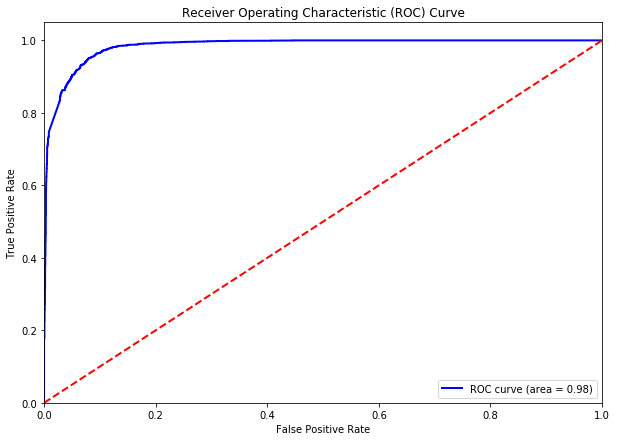

In [11]:
# ROC Curve
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label='spam')
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

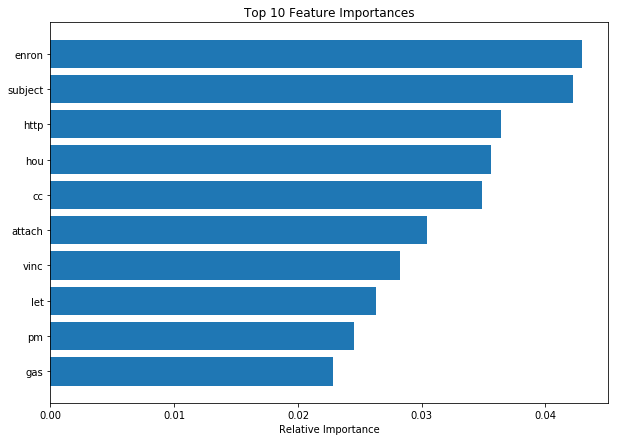

In [14]:
importances = best_model.feature_importances_
indices = sorted(range(len(importances)), key=lambda i: importances[i])[-10:]  # Top 10 features

plt.figure(figsize=(10, 7))
plt.barh(range(len(indices)), [importances[i] for i in indices], align='center')
plt.yticks(range(len(indices)), [vectorizer.get_feature_names()[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title('Top 10 Feature Importances')
plt.show()